In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
with open('../../inputs/0102_triangles.txt', 'r') as f:
    triangles_string = f.read()

To find if the origin $O$ was enclosed in a triangle $\triangle PQR$, then we can use vector algebra as discussed [here][1]. I implement both methods here.

[1]: https://blackpawn.com/texts/pointinpoly/default.html

In [28]:
raw_coords = [[int(t) for t in tri.split(',')] for tri in triangles_string.split('\n')]
triangles = np.array(raw_coords, int).reshape(1000,3,2)

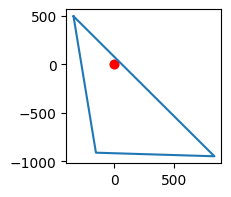

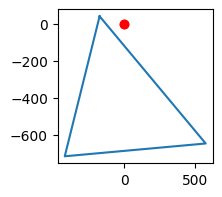

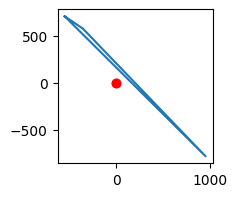

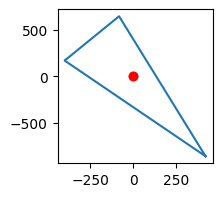

In [52]:
# plotting a few of the triangles to see
cntr = 0
for t in triangles:
    plt.figure(figsize = (2,2))
    plt.plot([t[i][0] for i in range(3)] + [t[0][0]], [t[i][1] for i in range(3)] + [t[0][1]])
    plt.scatter([0,0], [0,0], c='r')
    plt.show()
    cntr += 1
    if cntr >= 4:
        break

#### Same Side Technique


The first method uses the following fact:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Given four points $A, B, C, D$, if $C$ and $D$ are on the same side of $\overrightarrow{AB}$, then $\overrightarrow{AB} \times \overrightarrow{AC}$ and $\overrightarrow{AB} \times \overrightarrow{AD}$ point in the same direction.

With this in mind, we need three "same side" relationships:
1. $O$ and $R$ need to be on the same side of $\overrightarrow{PQ}$
2. $O$ and $Q$ need to be on the same side of $\overrightarrow{PR}$
3. $O$ and $P$ need to be on the same side of $\overrightarrow{QR}$

Since we are using only two dimensions $\langle i, j\rangle$, of course the cross product simply goes in the third dimension $\langle 0, 0, k\rangle$, and the direction is determined by the sign of $k$ (if we had more dimensions, we could use the sign of the dot product of the cross product pair). So we just need the sign of $k$ to be the same for each cross product pair. An easy way to check this is checking if the product of the two $k$'s is positive.

In [132]:
# "Same Side" technique, using cross products
def inside_triangle_ss(t, point):
    '''
    Given triangle t (as coordinates) and a point, returns True if 
    point is enclosed in triangle and False otherwise.
    '''

    vals = []
    for i,j,k in [(0,1,2), (0,2,1), (1,2,0)]:
        c1 = np.cross(t[j] - t[i], point - t[i])
        c2 = np.cross(t[j] - t[i], t[k] - t[i])

        vals.append(c1*c2)
    
    return not (np.array(vals, int) < 0).any()

origin = np.zeros(2)
cnt = 0
for t in triangles:
    cnt += inside_triangle_ss(t, origin)

print(cnt)

228


#### Barycentric Technique

This method uses algebra and planar/vector spaces to solve the problem. The idea is to set up a basis and show the origin either is in the span or not in the span. 

Suppose we have four point $A, B, C, D$ and we are interested in whether $D$ is enclosed in the triangle $\triangle ABC$. Then we can choose a starting point (say point $A$, WLOG), and calculate three vectors $v_0 = \overrightarrow{AB}, v_1 = \overrightarrow{AC}, v_2 = \overrightarrow{AD}$. In particular, our basis here is $[v_0, v_1]$ and we want to see if $v_2$ is in the span of $[v_0, v_1]$.

Suppose linear combinations are of the form $[x,y]$ so that $v_2 = xv_0 + yv_1$. If there were no constraints on the linear combinations, then of course (as long as $\frac{v_0}{|v_0|} \neq \frac{v_1}{|v_1|}$), then any vector $v_2$ is in the span. However, in order to remain within the triangle, we need to impose two constraints:
1. $x, y \geq 0$ since $x, y < 0$ would step "backwards" away from triangle
2. $x + y \leq 1$ since $x + y = 1$ represents exactly the side opposite of our starting point (in this case, $\overline{BC}$)

We can set up our problem as a matrix equation with vectors $v_0 = \langle a,d \rangle$, $v_1 = \langle b,e \rangle$, $v_2 = \langle c,f \rangle$:
$$
\begin{bmatrix} a & b \\ d & e \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} c \\ f \end{bmatrix}
$$

If we use matrix inverses, we may get floating point issues (although it works just fine for this problem, since the numbers are relatively small) so we can solve using Gaussian elimination.
$$
\begin{align*}
&\begin{bmatrix} a & b & | & c \\ d & e & | & f \end{bmatrix} \\ \\
\implies &\begin{bmatrix} ad & bd & | & cd \\ 0 & ae - bd & | & af - cd \end{bmatrix} \\ \\
\implies &\begin{bmatrix} (ae - bd)ad & 0 & | & (ae - bd)cd - (af - cd)bd \\ 0 & (ae - bd)bd & | & (af - cd)bd \end{bmatrix} \\ \\
\implies &\begin{bmatrix} 1 & 0 & | & \frac{ce - bf}{ae - bd} \\ 0 & 1 & | & \frac{af - cd}{ae - bd} \end{bmatrix} \\ \\
\implies &x = \frac{ce - bf}{ae - bd}, \quad y = \frac{af - cd}{ae - bd}
\end{align*}
$$

In [133]:
# using matrix inverse -- has floating point math, so won't work for high condition numbers
def inside_triangle_matrix(t, point):
    a, b, c = tuple(t)
    x, y = tuple(np.matmul(np.linalg.inv(np.array([b - a, c - a]).T), point - a))

    return x >= 0 and y >= 0 and x+y <= 1

origin = np.zeros(2)
cnt = 0
for t in triangles:
    cnt += inside_triangle_matrix(t, origin)

print(cnt)

228


In [134]:
# using gaussian elimination formulas that were already done above
def inside_triangle_bary(t, point):
    p, q, r = tuple(t)
    a, d = tuple(q - p)
    b, e = tuple(r - p)
    c, f = tuple(point - p)

    x = (c*e - b*f)/(a*e - b*d)
    y = (a*f - c*d)/(a*e - b*d)
    
    return x >= 0 and y >= 0 and x+y <= 1

origin = np.zeros(2)
cnt = 0
for t in triangles:
    cnt += inside_triangle_bary(t, origin)

print(cnt)

228
